# Imports

In [9]:
%%capture

!pip install category_encoders
!pip install statsmodels
!pip install pystan==2.19.1.1
!pip install prophet

In [10]:
import warnings; 
warnings.simplefilter('ignore')

In [68]:
from evaluation import eval_clf, half_round, eval_regr, eval_all

In [69]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier
import scipy as sp
import scipy.fftpack
# from fbprophet import Prophet
from prophet import Prophet
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler 

In [70]:
# df = pd.read_csv('data/mood.csv')
# df['time'] = pd.to_datetime(df['time'])
# df.head()

In [174]:
X_train = pd.read_csv('data/X_train.csv', index_col=0)
X_train_minmax_scaled = pd.read_csv('data/X_train_minmax_scaled.csv', index_col=0)
X_test = pd.read_csv('data/X_test.csv', index_col=0)
X_test_minmax_scaled = pd.read_csv('data/X_test_minmax_scaled.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)
y_test = pd.read_csv('data/y_test.csv', index_col=0)

# Task 2

## Evaluation

## Baselines

### Prevous mood as prediction

In [73]:
y_pred = X_test['mood']

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         0
         3.5       0.00      0.00      0.00         1
         5.0       0.40      0.40      0.40         5
         5.5       0.23      0.21      0.22        14
         6.0       0.33      0.32      0.32        44
         6.5       0.23      0.23      0.23        44
         7.0       0.57      0.58      0.58       157
         7.5       0.23      0.24      0.24        58
         8.0       0.31      0.30      0.31        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.39       385
   macro avg       0.21      0.21      0.21       385
weighted avg       0.39      0.39      0.39       385



{'Baseline same as previous day': {'f1': 0.39,
  'rounded_rmse': 0.55,
  'rmse': 0.54}}

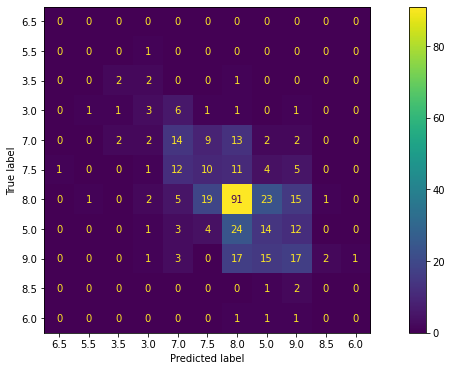

In [76]:
eval_all(y_test, y_pred, 'Baseline same as previous day')

### Average between prevous mood and one before as prediction

In [78]:
y_pred = (X_test['mood'] + X_test['prev_mood'])/2

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.5       0.00      0.00      0.00         0
         5.0       0.14      0.20      0.17         5
         5.5       0.38      0.21      0.27        14
         6.0       0.36      0.27      0.31        44
         6.5       0.23      0.32      0.27        44
         7.0       0.61      0.57      0.59       157
         7.5       0.24      0.38      0.29        58
         8.0       0.47      0.27      0.34        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41       385
   macro avg       0.22      0.20      0.20       385
weighted avg       0.44      0.41      0.41       385



{'Average between prevous mood and one before': {'f1': 0.41,
  'rounded_rmse': 0.48,
  'rmse': 0.45}}

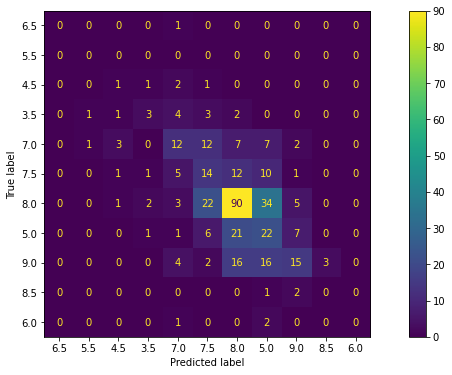

In [79]:
eval_all(y_test, y_pred, 'Average between prevous mood and one before')

### Average train mood as a baseline

In [91]:
avg_mood = np.mean(y_train)

y_pred = pd.DataFrame([avg_mood] * len(y_test))

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        44
         6.5       0.00      0.00      0.00        44
         7.0       0.41      1.00      0.58       157
         7.5       0.00      0.00      0.00        58
         8.0       0.00      0.00      0.00        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41       385
   macro avg       0.04      0.10      0.06       385
weighted avg       0.17      0.41      0.24       385



{'Average baseline': {'f1': 0.41, 'rounded_rmse': 0.54, 'rmse': 0.52}}

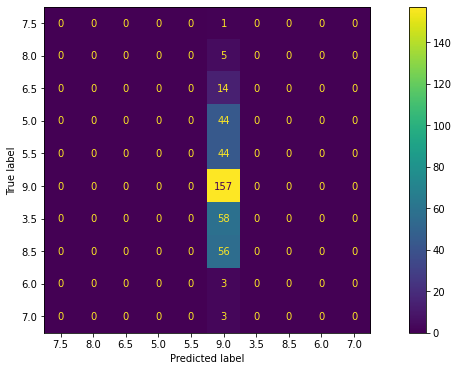

In [92]:
eval_all(y_test, y_pred, 'Average baseline')

## Feature Engineered model (8 points)

### SGD Regression

In [ ]:
# Grid search hyperparams
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
model = linear_model.SGDRegressor()

param_grid = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}

clf = GridSearchCV(model, param_grid, refit=True)
clf.fit(X_train_minmax_scaled, y_train)
print("Best score: " + str(clf.best_score_))
print("Best params: " + str(clf.best_params_))
model = clf.best_estimator_

In [ ]:
y_pred = pd.DataFrame(model.predict(X_train_minmax_scaled))
eval_all(y_train, y_pred, 'SGD Regression TRAIN')

In [ ]:
y_pred = pd.DataFrame(model.predict(X_test_minmax_scaled))
eval_all(y_test, y_pred, 'SGD Regression TEST')

In [ ]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);




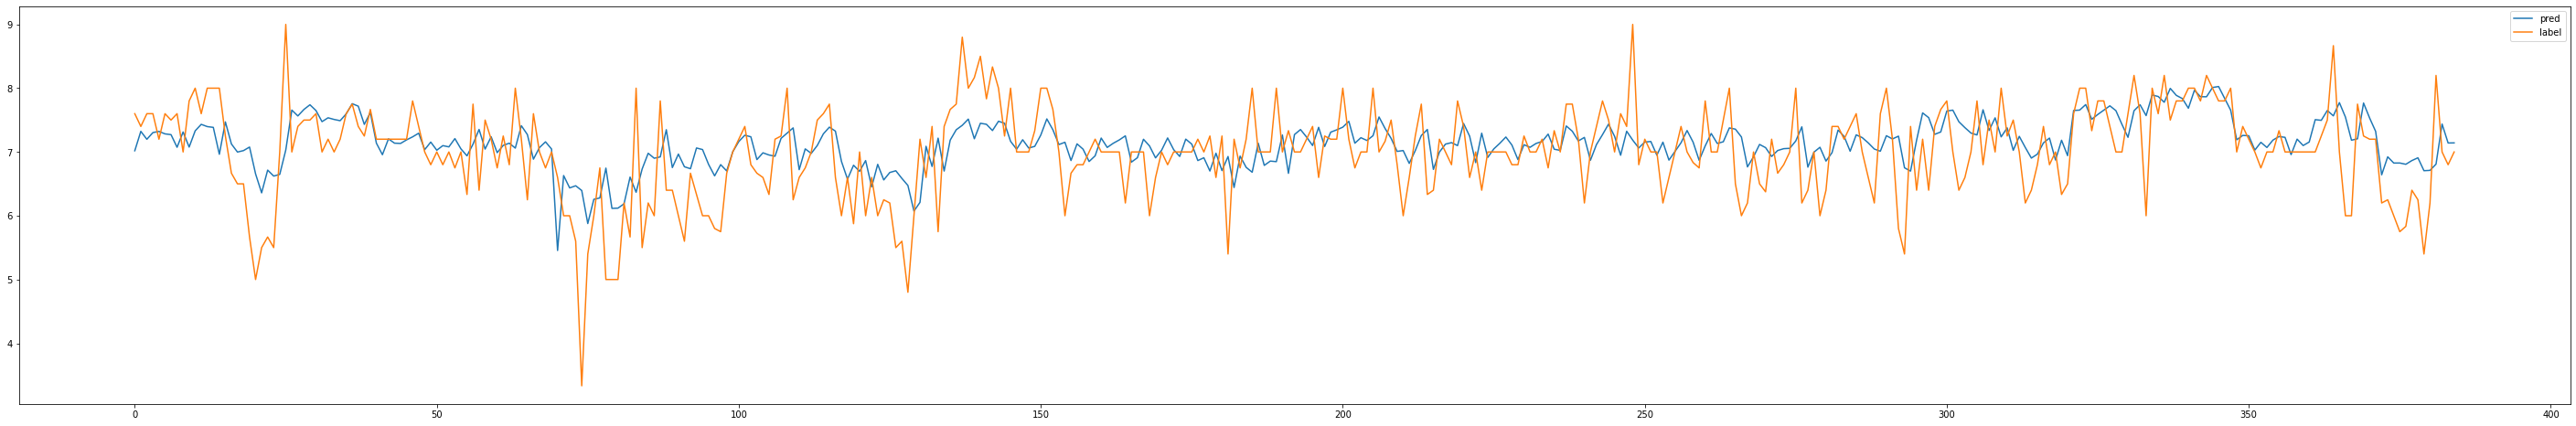

In [106]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(list(y_pred[0]), label='pred')
ax.plot(list(y_test['0']), label='label')
ax.legend()

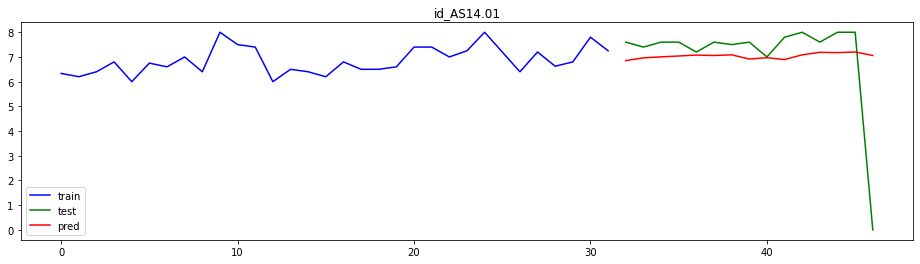

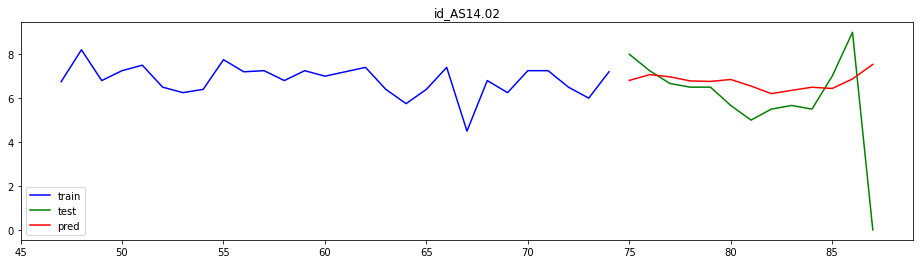

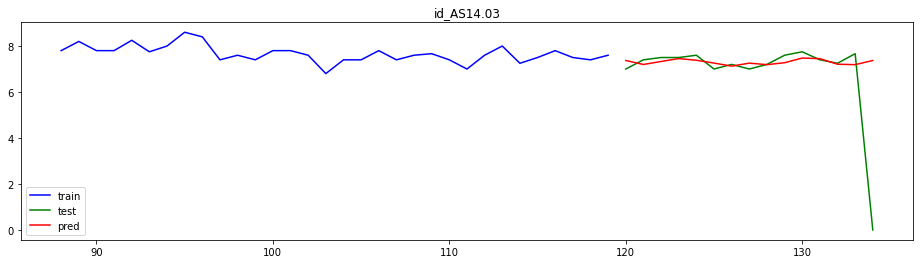

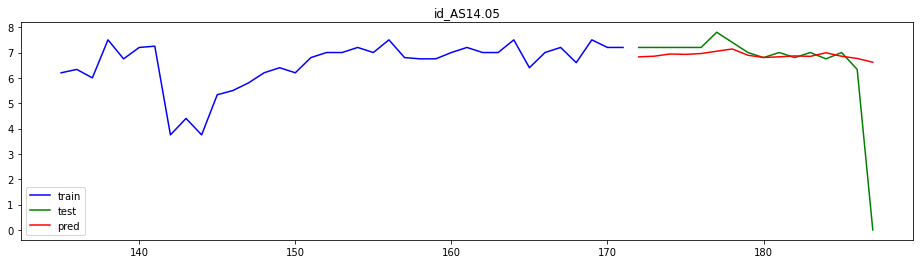

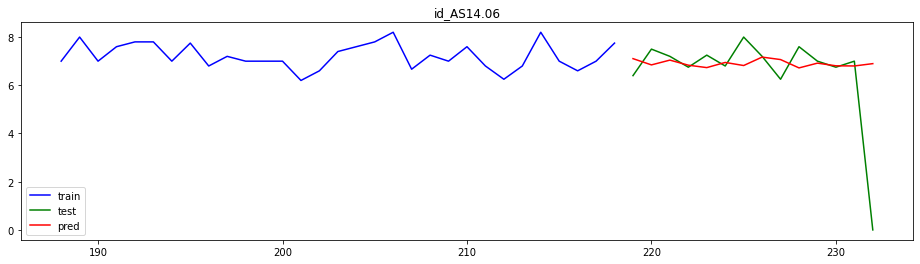

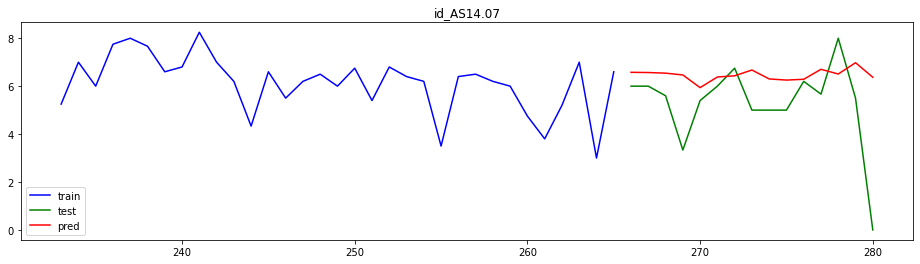

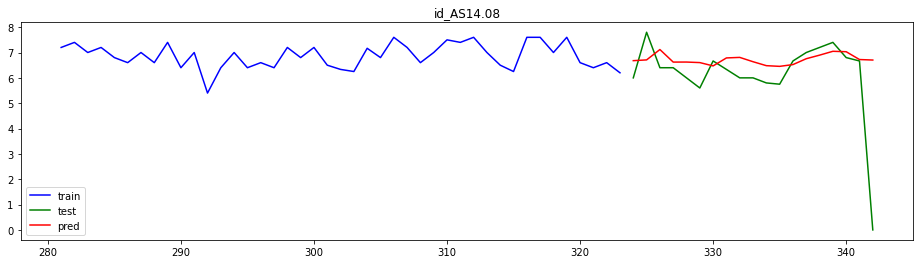

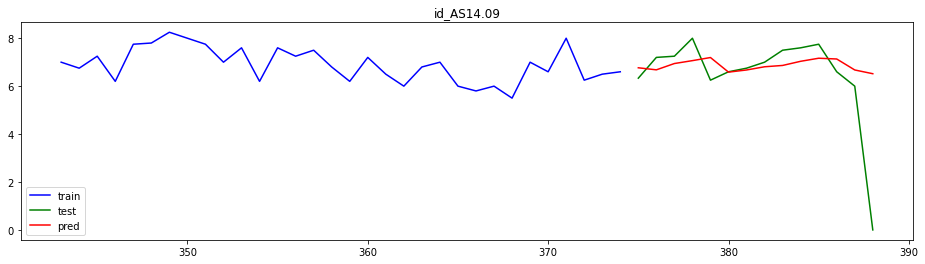

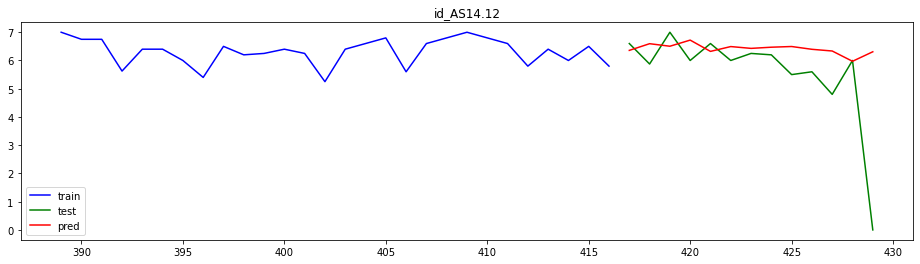

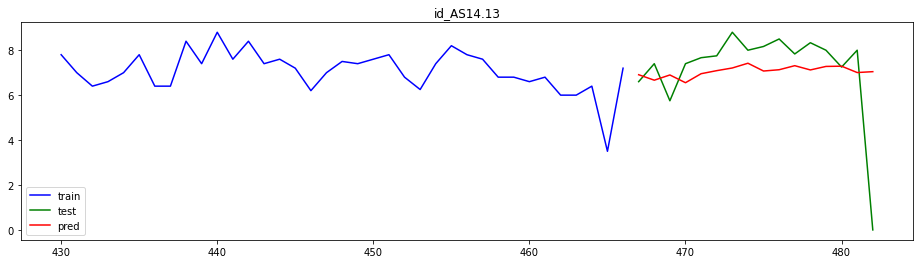

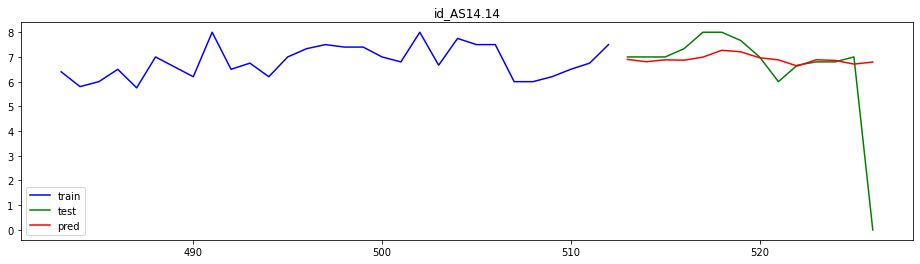

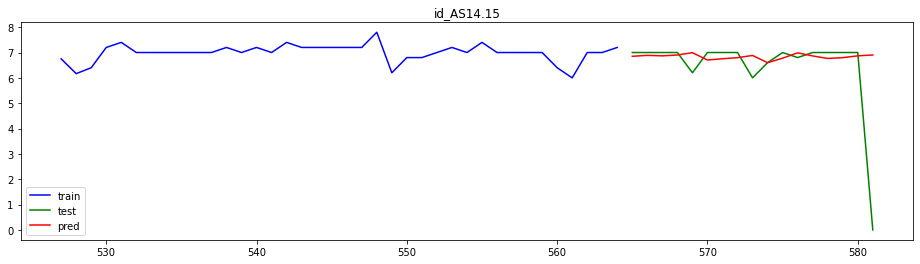

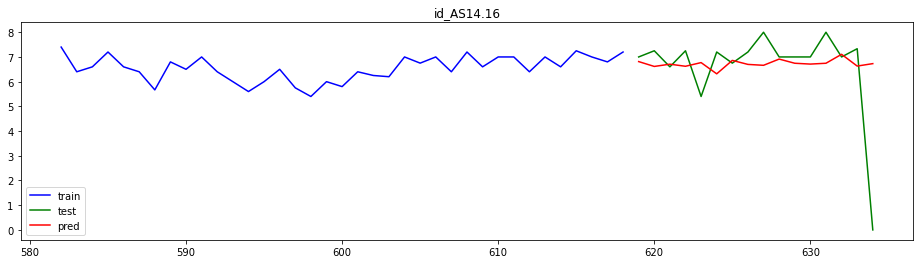

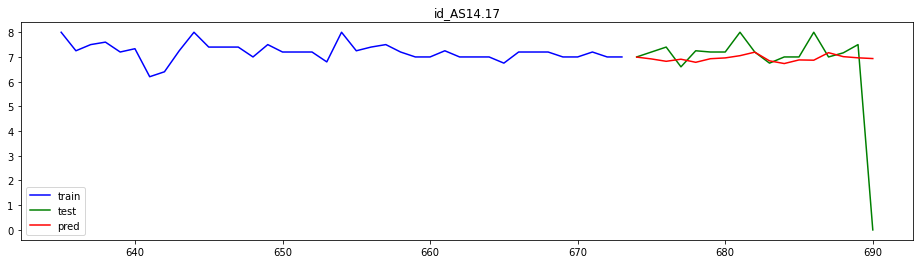

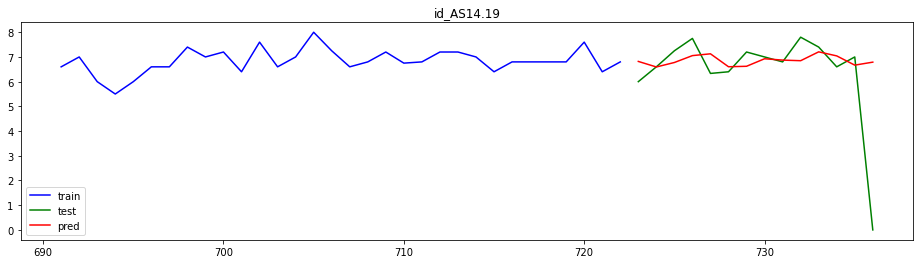

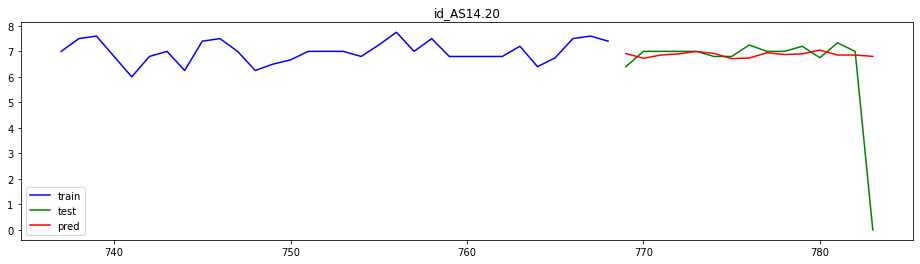

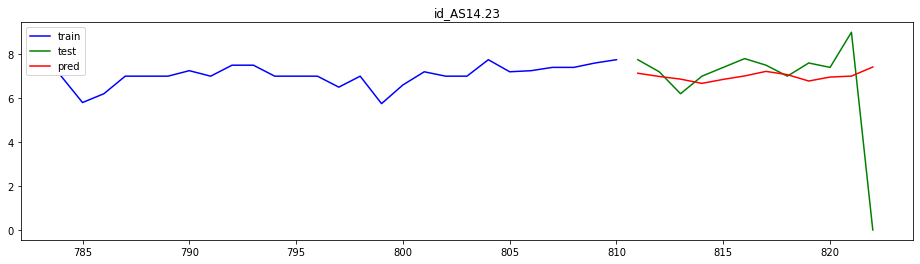

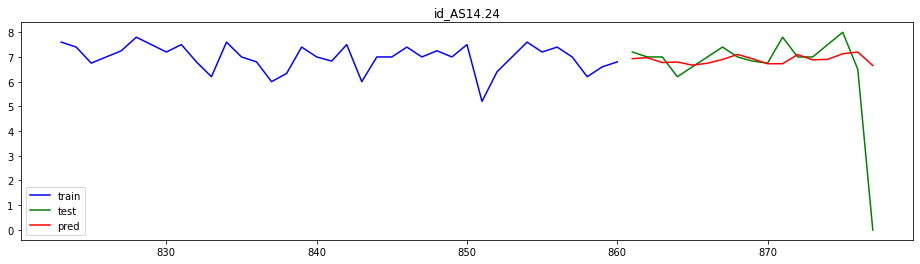

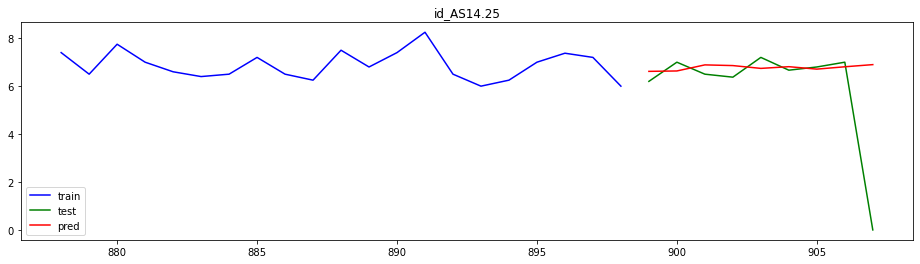

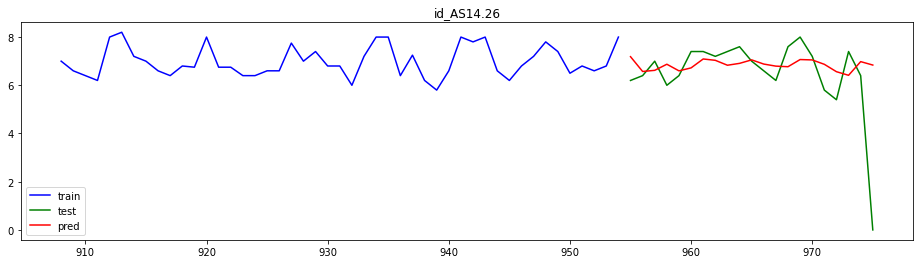

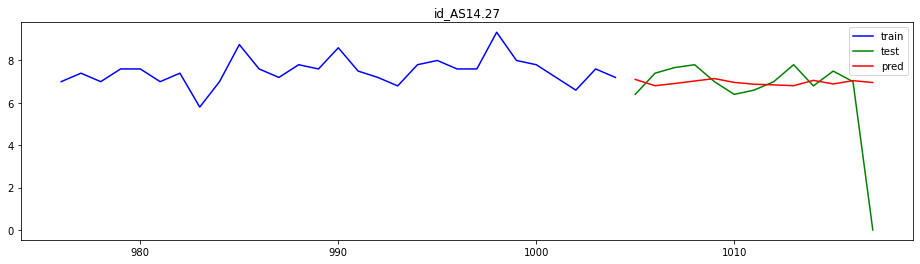

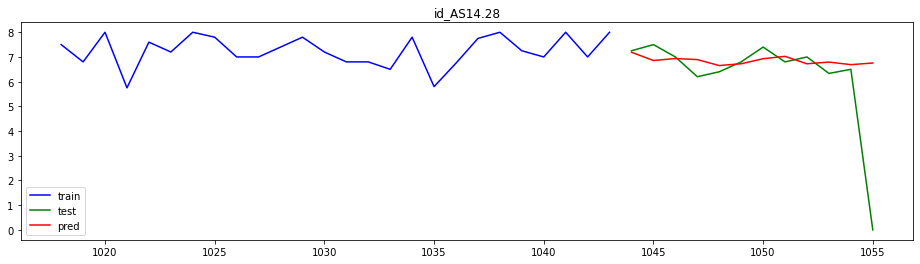

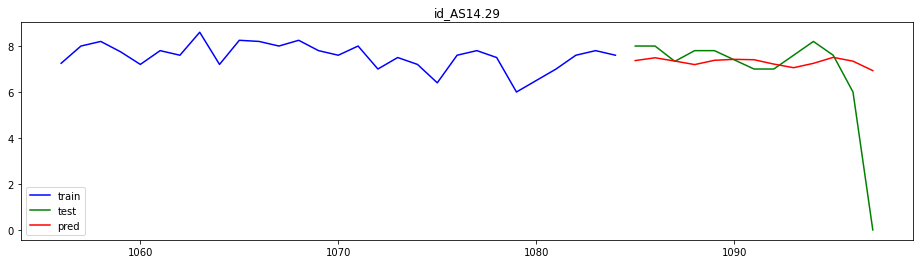

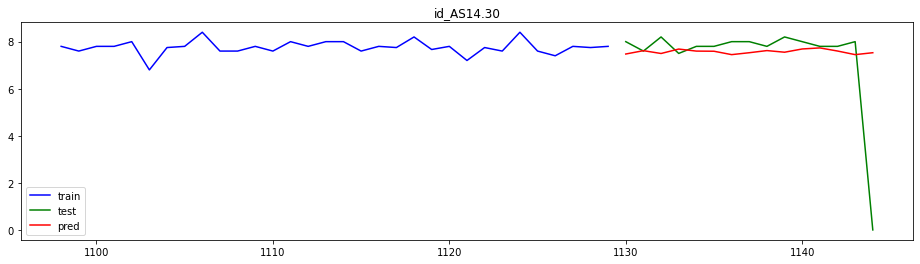

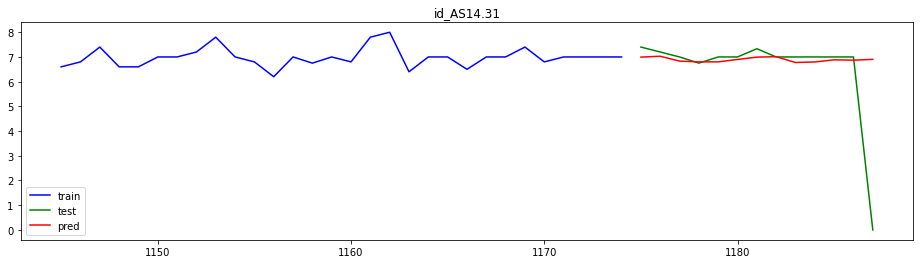

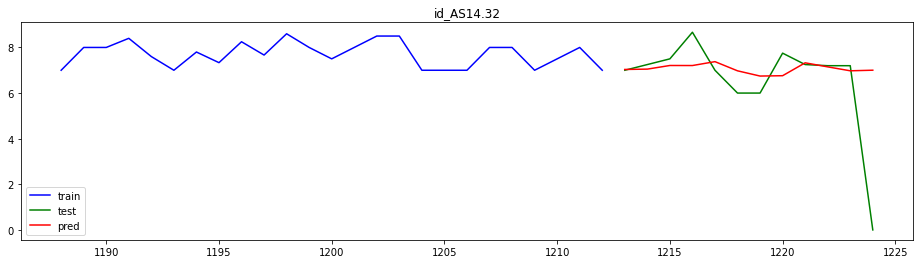

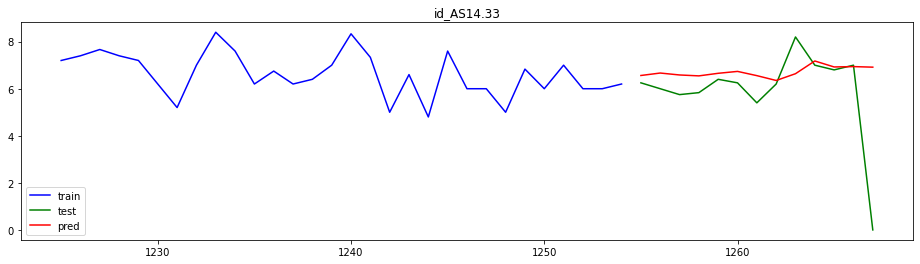

In [164]:
# # align index of test_pred with index of y_test
# test_pred = pd.concat([pd.DataFrame(y_test.index, columns=['index']), test_pred], axis=1).set_index('index')

# for idx in X_train.iloc[:,1:28].columns:
#     fig,ax = plt.subplots(figsize=(16,4))
#     ax.plot(y_train.loc[X_train[X_train[idx] == 1].index], label='train', c='b')
#     ax.plot(y_test.loc[X_test[X_test[idx] == 1].index], label='test', c='g')
#     ax.plot(test_pred.loc[X_test[X_test[idx] == 1].index], label='pred', c='r')
#     plt.legend()
#     plt.title(idx)

In [110]:
feature_importance = {}
feature_importance['feature'] = X_test_minmax_scaled.columns
feature_importance['importance'] = model.coef_
feature_importance['abs_importance'] = abs(feature_importance['importance'])
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values('abs_importance', ascending=False).head(25)

,feature,importance,abs_importance
27,mood,1.564984,1.564984
23,id_AS14.30,0.543904,0.543904
2,id_AS14.03,0.405387,0.405387
25,id_AS14.32,0.364591,0.364591
5,id_AS14.07,-0.352501,0.352501
22,id_AS14.29,0.317820,0.317820
12,id_AS14.16,-0.285775,0.285775
20,id_AS14.27,0.280641,0.280641
8,id_AS14.12,-0.225263,0.225263
61,"cos(3,freq=W-SUN)",0.161148,0.161148


### DecisionTreeClassifier

In [317]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train_minmax_scaled, half_round(y_train)*10)

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         3.5       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         3
         4.5       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         9
         5.5       0.00      0.00      0.00        13
         6.0       0.80      0.08      0.15        95
         6.5       0.45      0.12      0.19       129
         7.0       0.43      0.91      0.59       321
         7.5       0.36      0.27      0.31       146
         8.0       0.83      0.16      0.27       117
         8.5       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         2
         9.5       0.00      0.00      0.00         1

    accuracy                           0.44       856
   macro avg       0.20      0.11      0.11       856
weighted avg       0.49      0.44      0.35       856

probably, already rounded

{'DecisionTreeClassifier TRAIN': {'f1': 0.44,
  'rounded_rmse': 0.51,
  'rmse': 0.51}}

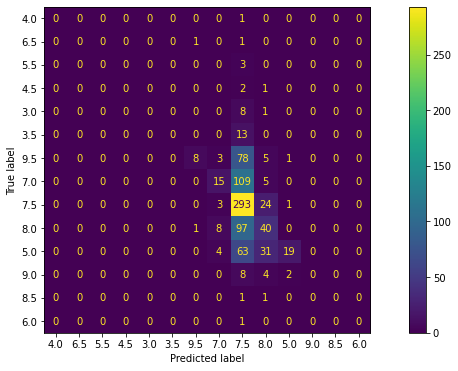

In [318]:
y_pred = pd.DataFrame(clf.predict(X_train_minmax_scaled))
eval_all(half_round(y_train), y_pred/10, 'DecisionTreeClassifier TRAIN')

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       1.00      0.02      0.04        44
         6.5       0.16      0.07      0.10        44
         7.0       0.44      0.87      0.58       157
         7.5       0.31      0.19      0.23        58
         8.0       0.44      0.12      0.19        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.41       385
   macro avg       0.23      0.13      0.12       385
weighted avg       0.42      0.41      0.32       385

probably, already rounded values were passed


{'DecisionTreeClassifier TEST': {'f1': 0.41,
  'rounded_rmse': 0.51,
  'rmse': 0.51}}

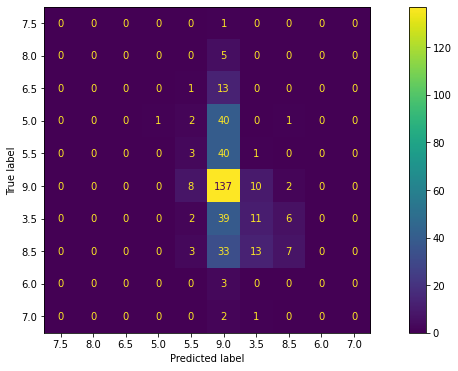

In [319]:
y_pred = pd.DataFrame(clf.predict(X_test_minmax_scaled))
eval_all(half_round(y_test), y_pred/10, 'DecisionTreeClassifier TEST')

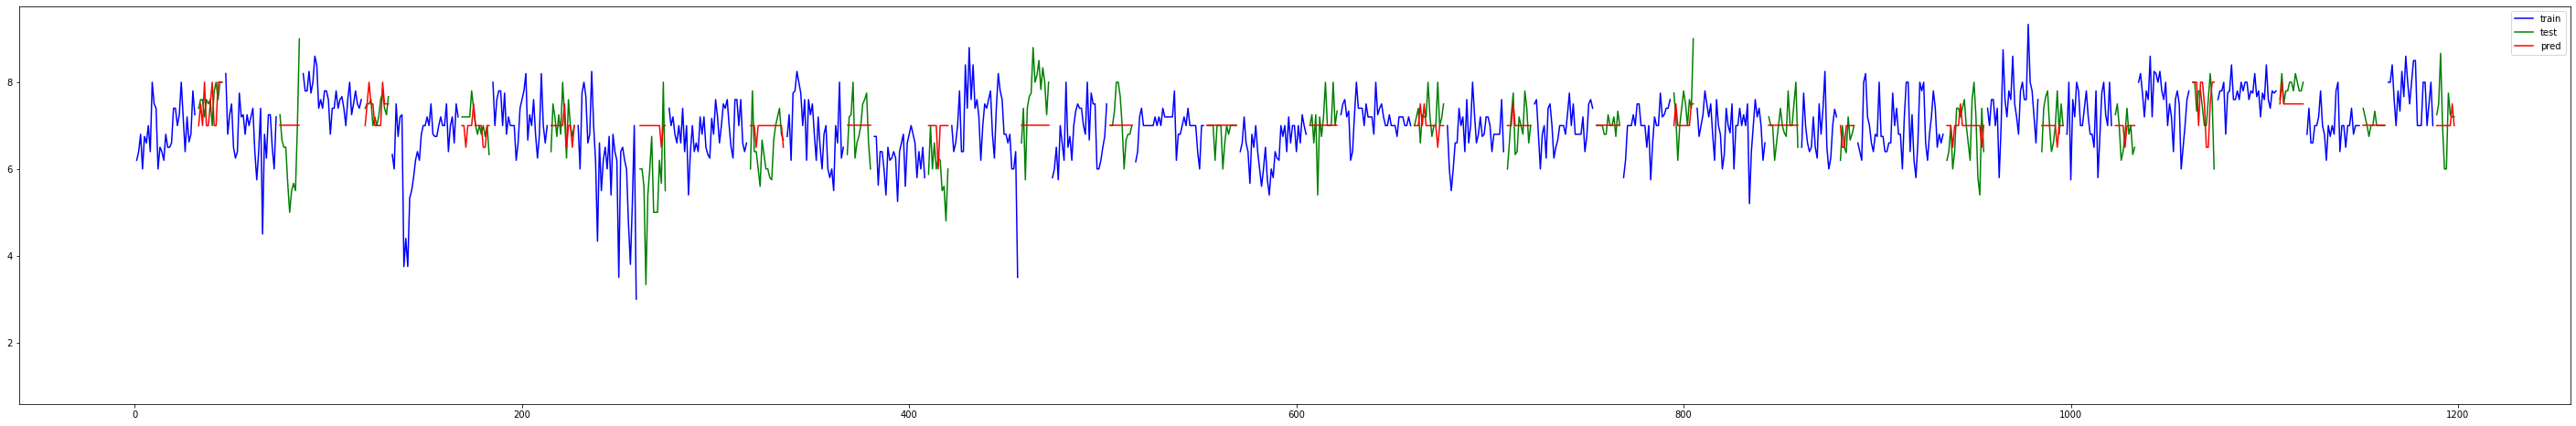

In [321]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')/10
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);




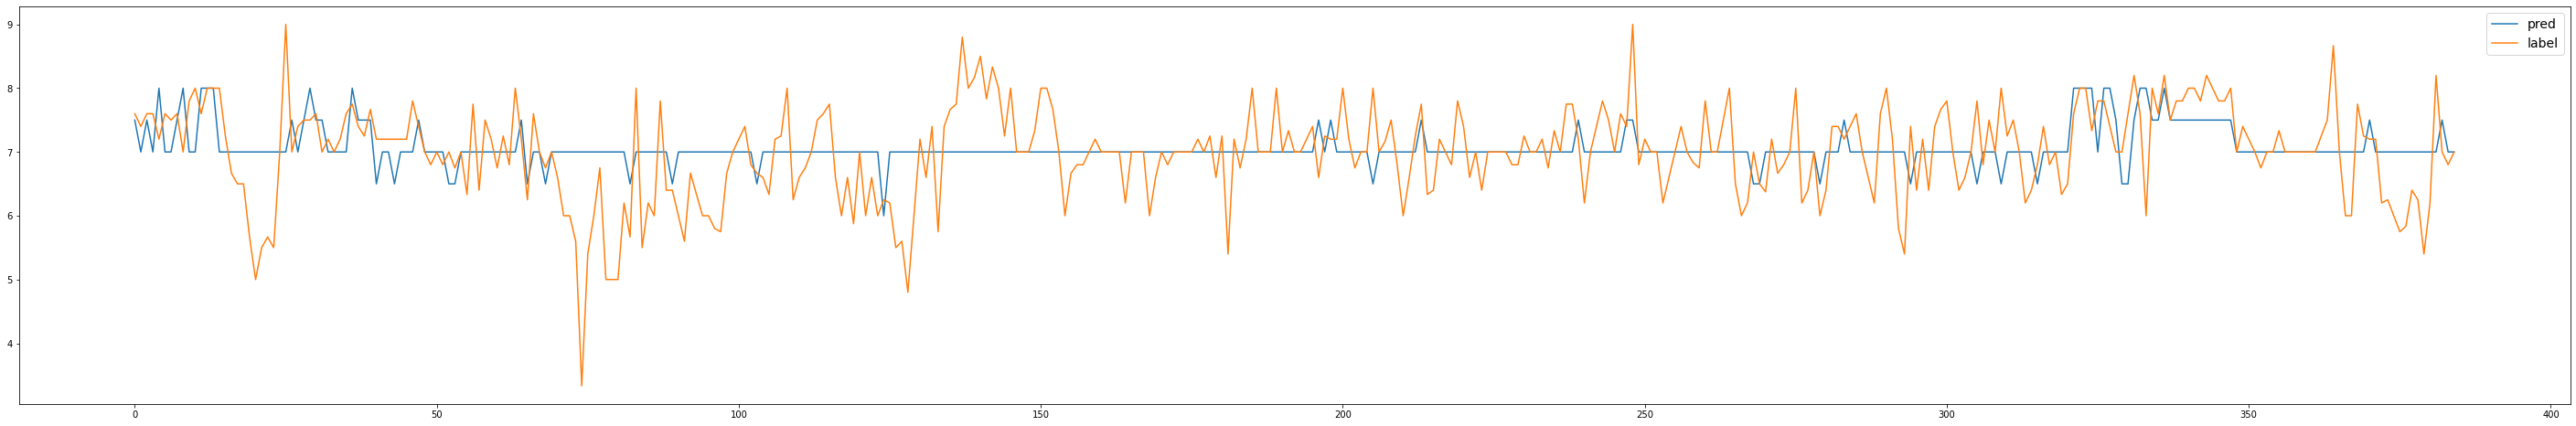

In [144]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(y_pred/10, label='pred')
ax.plot(y_test.values, label='label')
ax.legend(fontsize=14)

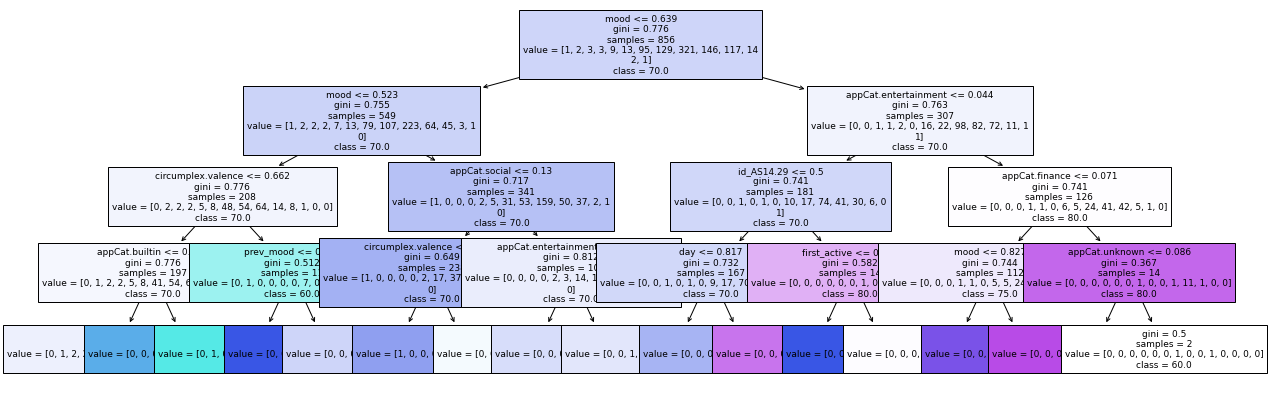

In [129]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(20, 7))

from sklearn import tree
tree.plot_tree(clf, 
               feature_names=X_test.columns, 
               class_names=[str(c) for c in clf.classes_],
            filled=True,
            max_depth=4,
            fontsize=9,
               );

### RandomForestClassifier

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [131]:
# features = ['mood',
#        'circumplex.arousal', 'circumplex.valence', 'activity',
#        'appCat.builtin', 'appCat.communication', 'appCat.entertainment',
#        'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other',
#        'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities',
#        'appCat.weather', 'call', 'screen', 'sms', 'asleep', 'active',
#        'missing_hour', 'mood_change', 'mood_prev1', 'day_num',
#        'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)',
#        'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         3.5       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         3
         4.5       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         9
         5.5       0.00      0.00      0.00        13
         6.0       0.00      0.00      0.00        95
         6.5       1.00      0.02      0.05       129
         7.0       0.40      0.99      0.57       321
         7.5       0.92      0.08      0.14       146
         8.0       0.72      0.25      0.37       117
         8.5       0.00      0.00      0.00        14
         9.0       0.00      0.00      0.00         2
         9.5       0.00      0.00      0.00         1

    accuracy                           0.42       856
   macro avg       0.22      0.10      0.08       856
weighted avg       0.56      0.42      0.29       856

probably, already rounded

{'RandomForestClassifier TRAIN': {'f1': 0.42,
  'rounded_rmse': 0.51,
  'rmse': 0.51}}

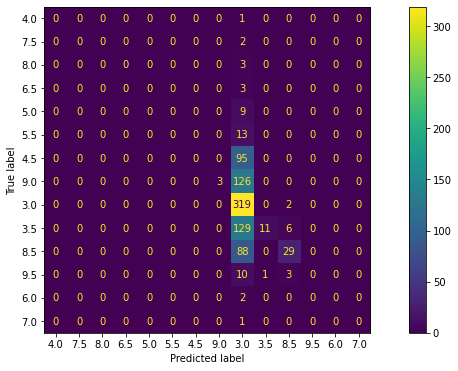

In [177]:
clf = RandomForestClassifier(max_depth=4)
clf = clf.fit(X_train_minmax_scaled, half_round(y_train)*10)


y_pred = pd.DataFrame(clf.predict(X_train_minmax_scaled))
eval_all(half_round(y_train), y_pred/10, 'RandomForestClassifier TRAIN')

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         5.0       0.00      0.00      0.00         5
         5.5       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        44
         6.5       0.00      0.00      0.00        44
         7.0       0.42      0.99      0.59       157
         7.5       0.00      0.00      0.00        58
         8.0       0.86      0.21      0.34        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.44       385
   macro avg       0.13      0.12      0.09       385
weighted avg       0.30      0.44      0.29       385

probably, already rounded values were passed


{'RandomForestClassifier TEST': {'f1': 0.44,
  'rounded_rmse': 0.51,
  'rmse': 0.51}}

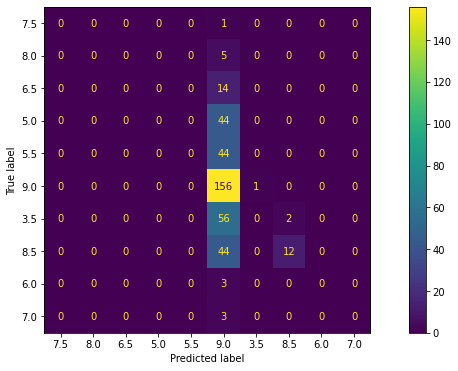

In [306]:
y_pred = pd.DataFrame(clf.predict(X_test_minmax_scaled))
eval_all(half_round(y_test), y_pred/10, 'RandomForestClassifier TEST')

In [275]:
for el in sorted(zip(X_train_minmax_scaled.columns, clf.feature_importances_), key=lambda x: x[1], 
                 reverse=True):
    print(el)

('mood', 0.1353629884872882)
('prev_mood', 0.07152686160782118)
('appCat.social', 0.055269380241111825)
('appCat.other', 0.04586760245021322)
('circumplex.valence', 0.04546760006468118)
('screen', 0.037813209725907584)
('appCat.entertainment', 0.03592795948495931)
('id_AS14.30', 0.032571818757219394)
('activity', 0.02988625288257394)
('appCat.communication', 0.028718790724978505)
('appCat.builtin', 0.02671409702554644)
('id_AS14.03', 0.02473094592328796)
('appCat.office', 0.024220317115028284)
('appCat.travel', 0.02103733180458744)
('dayofyear', 0.02016628610839645)
('id_AS14.15', 0.020050405082899733)
('appCat.finance', 0.019219166873979628)
('asleep', 0.018896105245250473)
('first_active_change', 0.018093907464237134)
('day', 0.017374707108714204)
('appCat.unknown', 0.015463717290813068)
('circumplex.arousal', 0.015218610700902245)
('call', 0.014518035689829987)
('sin(3,freq=W-SUN)', 0.01410716073001286)
('first_active', 0.012698275762817702)
('appCat.weather', 0.012675109912246548)


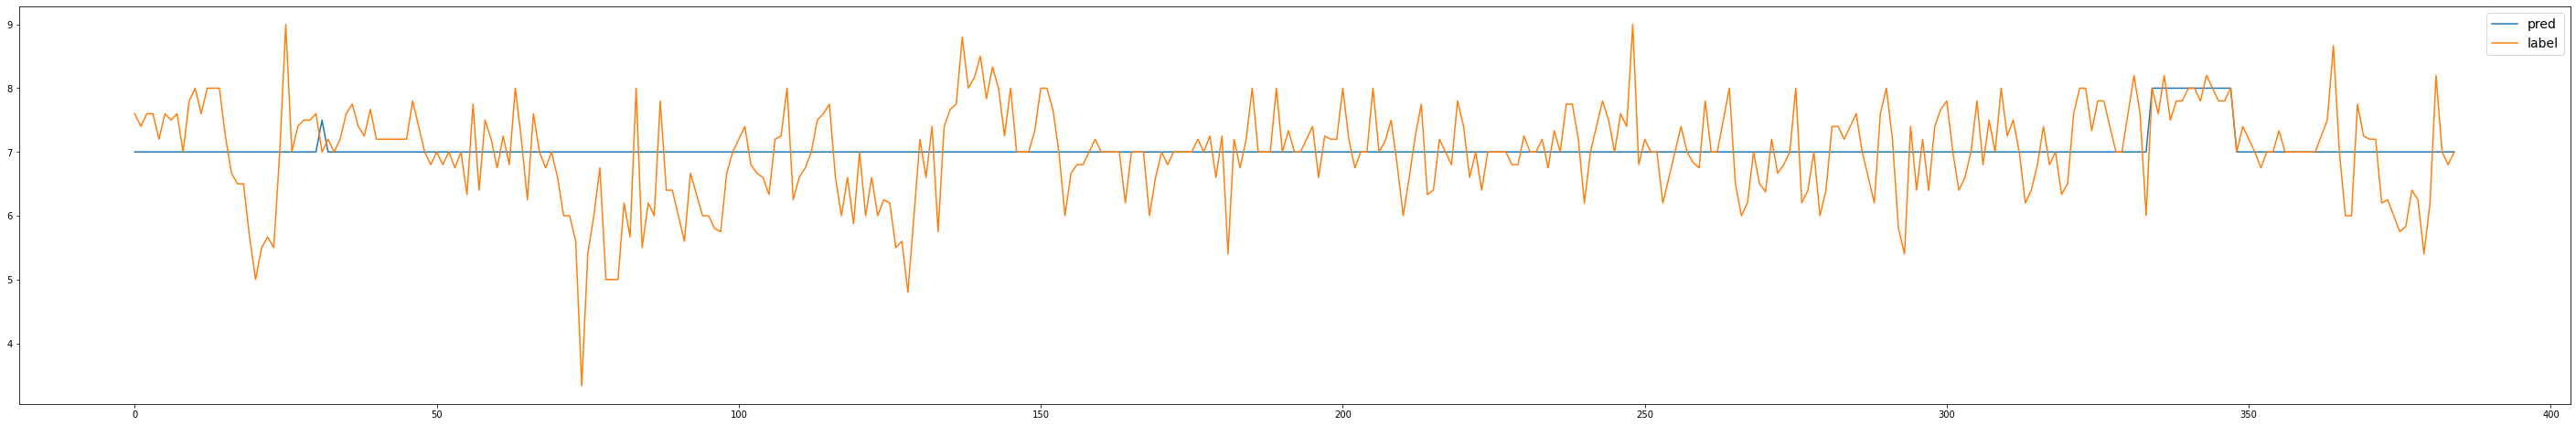

In [252]:
fig,ax = plt.subplots(figsize=(50,8))
ax.plot(y_pred/10, label='pred')
ax.plot(y_test.values, label='label')
ax.legend(fontsize=14)

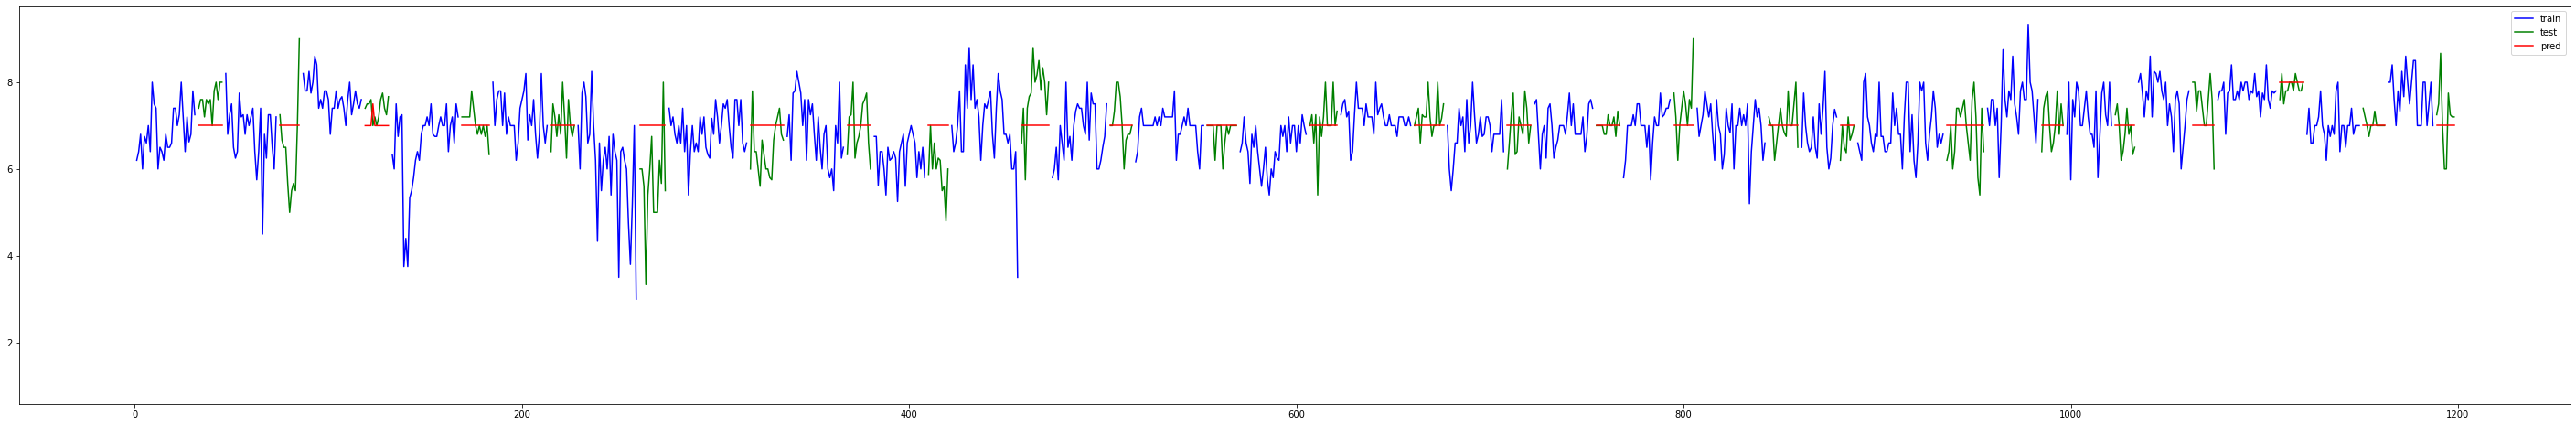

In [288]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')/10
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);


### TPOT

In [151]:
%%capture
!pip install tpot

In [152]:
X_train_minmax_scaled['mood'] = X_train_minmax_scaled['mood'].apply(lambda x: round(x))
X_train_minmax_scaled['prev_mood'] = X_train_minmax_scaled['prev_mood'].apply(lambda x: round(x))

X_test_minmax_scaled['mood'] = X_test_minmax_scaled['mood'].apply(lambda x: round(x))
X_test_minmax_scaled['prev_mood'] = X_test_minmax_scaled['prev_mood'].apply(lambda x: round(x))

In [154]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, 
                      random_state=42,
                      n_jobs=-1,
                    #   config_dict='TPOT NN'
                      )
tpot.fit(X_train_minmax_scaled, y_train)
print(tpot.score(X_test_minmax_scaled, y_test))

# export the minimalized code for the best model found
tpot.export('tpot_fb_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklear



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: MLPClassifier(input_matrix, alpha=0.0001, learning_rate_init=1.0)
0.5272727272727272


## Temporal Model 8

TODO NED: add plots

### AR model

### ARIMA

In [ ]:
y = train_test_dict['AS14.01']['train']

# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

for participant in sorted(model_dict.keys()):
    model = model_dict[participant]
    print(f"{participant}\t\tAIC: {np.round(model.aic(), 2):.2f}\tBIC: {np.round(model.bic(), 2):.2f}\tParameters: {model.order}")

### Prophet

In [311]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)


y_pred = pd.DataFrame()
for idx in train['id'].unique():
    train_current = train[train['id'] == idx][['time', 'next_mood']].rename(columns={'time': 'ds', 'next_mood': 'y'})
    test_current = test[test['id'] == idx][['time', 'next_mood']].rename(columns={'time': 'ds', 'next_mood': 'y'})

    m = Prophet(interval_width=0.95, weekly_seasonality=True);
    model = m.fit(train_current);

    if len(test_current['ds']) > 0:
        forecast = m.predict(pd.DataFrame(test_current['ds']));
        y_pred = pd.concat([y_pred, forecast['yhat']])
    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.831233
Iteration  1. Log joint probability =    44.9048. Improved by 45.736.
Iteration  2. Log joint probability =     71.968. Improved by 27.0632.
Iteration  3. Log joint probability =    73.6236. Improved by 1.6556.
Iteration  4. Log joint probability =    77.3756. Improved by 3.75208.
Iteration  5. Log joint probability =    77.5398. Improved by 0.164124.
Iteration  6. Log joint probability =    77.5685. Improved by 0.0287192.
Iteration  7. Log joint probability =    77.5784. Improved by 0.00990995.
Iteration  8. Log joint probability =    77.5851. Improved by 0.00669544.
Iteration  9. Log joint probability =    77.5871. Improved by 0.00204689.
Iteration 10. Log joint probability =    77.5983. Improved by 0.0111877.
Iteration 11. Log joint probability =    77.6091. Improved by 0.0107963.
Iteration 12. Log joint probability =     77.645. Improved by 0.03586.
Iteration 13. Log joint probability =    77.7298. Improved by 0.0848486.
Iteration 14. Log 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.12491
Iteration  1. Log joint probability =    28.9095. Improved by 33.0344.
Iteration  2. Log joint probability =    53.3326. Improved by 24.4231.
Iteration  3. Log joint probability =     57.073. Improved by 3.74039.
Iteration  4. Log joint probability =    57.4283. Improved by 0.355372.
Iteration  5. Log joint probability =    57.4747. Improved by 0.0463233.
Iteration  6. Log joint probability =    57.5241. Improved by 0.0494145.
Iteration  7. Log joint probability =    57.5654. Improved by 0.0413058.
Iteration  8. Log joint probability =    57.6057. Improved by 0.0402668.
Iteration  9. Log joint probability =    57.6558. Improved by 0.0500997.
Iteration 10. Log joint probability =    57.9332. Improved by 0.277443.
Iteration 11. Log joint probability =    57.9936. Improved by 0.0604369.
Iteration 12. Log joint probability =     58.204. Improved by 0.210363.
Iteration 13. Log joint probability =    58.2331. Improved by 0.0290749.
Iteration 14. Log 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.797926
Iteration  1. Log joint probability =    59.0035. Improved by 59.8014.
Iteration  2. Log joint probability =    77.6962. Improved by 18.6928.
Iteration  3. Log joint probability =    80.0421. Improved by 2.34584.
Iteration  4. Log joint probability =    85.2379. Improved by 5.19578.
Iteration  5. Log joint probability =    85.3237. Improved by 0.0858918.
Iteration  6. Log joint probability =    85.4489. Improved by 0.125122.
Iteration  7. Log joint probability =    85.5616. Improved by 0.112687.
Iteration  8. Log joint probability =    85.7608. Improved by 0.199217.
Iteration  9. Log joint probability =    85.9009. Improved by 0.140133.
Iteration 10. Log joint probability =    85.9355. Improved by 0.0345465.
Iteration 11. Log joint probability =    86.0853. Improved by 0.149851.
Iteration 12. Log joint probability =    86.0867. Improved by 0.00141767.
Iteration 13. Log joint probability =     92.227. Improved by 6.14031.
Iteration 14. Log join

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -2.38387
Iteration  1. Log joint probability =    13.0745. Improved by 15.4584.
Iteration  2. Log joint probability =     59.136. Improved by 46.0615.
Iteration  3. Log joint probability =    62.1685. Improved by 3.03255.
Iteration  4. Log joint probability =    62.3693. Improved by 0.200746.
Iteration  5. Log joint probability =    62.5579. Improved by 0.188673.
Iteration  6. Log joint probability =    62.6095. Improved by 0.0515542.
Iteration  7. Log joint probability =    62.6211. Improved by 0.0116447.
Iteration  8. Log joint probability =    62.6373. Improved by 0.0162001.
Iteration  9. Log joint probability =    62.7005. Improved by 0.0631877.
Iteration 10. Log joint probability =    62.7448. Improved by 0.0442469.
Iteration 11. Log joint probability =    62.7854. Improved by 0.04066.
Iteration 12. Log joint probability =     62.787. Improved by 0.00160203.
Iteration 13. Log joint probability =    62.8683. Improved by 0.0813113.
Iteration 14. Log 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.30529
Iteration  1. Log joint probability =    43.6418. Improved by 44.9471.
Iteration  2. Log joint probability =     61.741. Improved by 18.0991.
Iteration  3. Log joint probability =    68.7251. Improved by 6.98407.
Iteration  4. Log joint probability =    69.9452. Improved by 1.22017.
Iteration  5. Log joint probability =    69.9989. Improved by 0.0536329.
Iteration  6. Log joint probability =    70.0097. Improved by 0.0108316.
Iteration  7. Log joint probability =    70.0162. Improved by 0.00652719.
Iteration  8. Log joint probability =    70.0362. Improved by 0.0200313.
Iteration  9. Log joint probability =    70.0541. Improved by 0.0178474.
Iteration 10. Log joint probability =    70.1025. Improved by 0.0484343.
Iteration 11. Log joint probability =    70.1455. Improved by 0.0429858.
Iteration 12. Log joint probability =    70.1977. Improved by 0.0522224.
Iteration 13. Log joint probability =    70.2246. Improved by 0.0268995.
Iteration 14. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -1.95071
Iteration  1. Log joint probability =    22.1958. Improved by 24.1465.
Iteration  2. Log joint probability =     33.208. Improved by 11.0122.
Iteration  3. Log joint probability =    51.8419. Improved by 18.6339.
Iteration  4. Log joint probability =    51.9626. Improved by 0.120738.
Iteration  5. Log joint probability =    52.0081. Improved by 0.0455033.
Iteration  6. Log joint probability =    52.0386. Improved by 0.0305201.
Iteration  7. Log joint probability =    52.1046. Improved by 0.0659445.
Iteration  8. Log joint probability =    52.1503. Improved by 0.0457247.
Iteration  9. Log joint probability =    52.1516. Improved by 0.00130805.
Iteration 10. Log joint probability =    52.1753. Improved by 0.0237172.
Iteration 11. Log joint probability =    52.1848. Improved by 0.00946334.
Iteration 12. Log joint probability =    52.1892. Improved by 0.00444445.
Iteration 13. Log joint probability =    52.2007. Improved by 0.0115023.
Iteration 14.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -7.76334
Iteration  1. Log joint probability =    53.5189. Improved by 61.2822.
Iteration  2. Log joint probability =    82.3326. Improved by 28.8137.
Iteration  3. Log joint probability =    96.8047. Improved by 14.4722.
Iteration  4. Log joint probability =    99.2399. Improved by 2.43516.
Iteration  5. Log joint probability =     99.654. Improved by 0.414079.
Iteration  6. Log joint probability =    99.7094. Improved by 0.0553804.
Iteration  7. Log joint probability =    99.7233. Improved by 0.0139222.
Iteration  8. Log joint probability =    99.7413. Improved by 0.0179881.
Iteration  9. Log joint probability =    99.7657. Improved by 0.0243826.
Iteration 10. Log joint probability =    99.7792. Improved by 0.0135007.
Iteration 11. Log joint probability =    99.7796. Improved by 0.000454337.
Iteration 12. Log joint probability =    99.7826. Improved by 0.00294867.
Iteration 13. Log joint probability =    99.7931. Improved by 0.0105535.
Iteration 14. L

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -2.26077
Iteration  1. Log joint probability =    27.3384. Improved by 29.5992.
Iteration  2. Log joint probability =    62.6034. Improved by 35.2651.
Iteration  3. Log joint probability =    64.4966. Improved by 1.89318.
Iteration  4. Log joint probability =    64.5168. Improved by 0.0202325.
Iteration  5. Log joint probability =     64.586. Improved by 0.0691707.
Iteration  6. Log joint probability =    64.6174. Improved by 0.0313409.
Iteration  7. Log joint probability =    64.6454. Improved by 0.0279916.
Iteration  8. Log joint probability =     64.685. Improved by 0.0396725.
Iteration  9. Log joint probability =    64.7739. Improved by 0.0888951.
Iteration 10. Log joint probability =    64.8159. Improved by 0.0420164.
Iteration 11. Log joint probability =    64.8666. Improved by 0.0506726.
Iteration 12. Log joint probability =    67.9676. Improved by 3.10095.
Iteration 13. Log joint probability =    67.9745. Improved by 0.00693424.
Iteration 14. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.08735
Iteration  1. Log joint probability =    38.2014. Improved by 42.2887.
Iteration  2. Log joint probability =    55.8565. Improved by 17.6551.
Iteration  3. Log joint probability =    63.9163. Improved by 8.05976.
Iteration  4. Log joint probability =    63.9189. Improved by 0.00262481.
Iteration  5. Log joint probability =    63.9211. Improved by 0.00222759.
Iteration  6. Log joint probability =    63.9278. Improved by 0.0066827.
Iteration  7. Log joint probability =    64.0119. Improved by 0.0840633.
Iteration  8. Log joint probability =    64.2437. Improved by 0.231769.
Iteration  9. Log joint probability =    64.3581. Improved by 0.114406.
Iteration 10. Log joint probability =    64.3886. Improved by 0.0304882.
Iteration 11. Log joint probability =    64.4406. Improved by 0.0520155.
Iteration 12. Log joint probability =    64.4578. Improved by 0.0172127.
Iteration 13. Log joint probability =    64.4607. Improved by 0.00289179.
Iteration 14. 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -2.99148
Iteration  1. Log joint probability =    26.8238. Improved by 29.8153.
Iteration  2. Log joint probability =    46.6494. Improved by 19.8256.
Iteration  3. Log joint probability =    67.3164. Improved by 20.667.
Iteration  4. Log joint probability =    68.6761. Improved by 1.35979.
Iteration  5. Log joint probability =    68.7454. Improved by 0.0692581.
Iteration  6. Log joint probability =    68.8779. Improved by 0.132478.
Iteration  7. Log joint probability =    68.9322. Improved by 0.05434.
Iteration  8. Log joint probability =    68.9339. Improved by 0.0017003.
Iteration  9. Log joint probability =    68.9487. Improved by 0.0147424.
Iteration 10. Log joint probability =    68.9533. Improved by 0.00466359.
Iteration 11. Log joint probability =    68.9583. Improved by 0.00493179.
Iteration 12. Log joint probability =    68.9616. Improved by 0.00338268.
Iteration 13. Log joint probability =    68.9649. Improved by 0.00321105.
Iteration 14. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -1.33248
Iteration  1. Log joint probability =    39.4514. Improved by 40.7839.
Iteration  2. Log joint probability =    59.3412. Improved by 19.8897.
Iteration  3. Log joint probability =     63.116. Improved by 3.77481.
Iteration  4. Log joint probability =    64.4893. Improved by 1.37328.
Iteration  5. Log joint probability =     64.497. Improved by 0.00776232.
Iteration  6. Log joint probability =     64.528. Improved by 0.0309673.
Iteration  7. Log joint probability =    64.6849. Improved by 0.156886.
Iteration  8. Log joint probability =    64.7078. Improved by 0.0228818.
Iteration  9. Log joint probability =    64.7532. Improved by 0.0454589.
Iteration 10. Log joint probability =    64.8472. Improved by 0.0939969.
Iteration 11. Log joint probability =    64.9058. Improved by 0.0586131.
Iteration 12. Log joint probability =    64.9213. Improved by 0.0154236.
Iteration 13. Log joint probability =    64.9297. Improved by 0.0084654.
Iteration 14. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -3.10696
Iteration  1. Log joint probability =    59.1097. Improved by 62.2166.
Iteration  2. Log joint probability =    92.3807. Improved by 33.271.
Iteration  3. Log joint probability =    98.1946. Improved by 5.81389.
Iteration  4. Log joint probability =    98.2433. Improved by 0.0487633.
Iteration  5. Log joint probability =    98.2903. Improved by 0.0469755.
Iteration  6. Log joint probability =    98.3028. Improved by 0.0125043.
Iteration  7. Log joint probability =    98.3275. Improved by 0.0246497.
Iteration  8. Log joint probability =    98.3323. Improved by 0.00483401.
Iteration  9. Log joint probability =    98.6444. Improved by 0.312123.
Iteration 10. Log joint probability =    98.7198. Improved by 0.0753974.
Iteration 11. Log joint probability =    98.7675. Improved by 0.0477018.
Iteration 12. Log joint probability =    98.7781. Improved by 0.0105295.
Iteration 13. Log joint probability =    98.7844. Improved by 0.00631572.
Iteration 14. L

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -2.36561
Iteration  1. Log joint probability =    38.5344. Improved by 40.9001.
Iteration  2. Log joint probability =    61.6754. Improved by 23.1409.
Iteration  3. Log joint probability =    75.6651. Improved by 13.9898.
Iteration  4. Log joint probability =    81.0924. Improved by 5.4273.
Iteration  5. Log joint probability =    81.8026. Improved by 0.71019.
Iteration  6. Log joint probability =    81.8301. Improved by 0.0274878.
Iteration  7. Log joint probability =    81.8586. Improved by 0.0284911.
Iteration  8. Log joint probability =    81.9605. Improved by 0.101896.
Iteration  9. Log joint probability =    82.0066. Improved by 0.0461216.
Iteration 10. Log joint probability =    82.0127. Improved by 0.00605636.
Iteration 11. Log joint probability =     82.107. Improved by 0.0943309.
Iteration 12. Log joint probability =    82.1537. Improved by 0.0467342.
Iteration 13. Log joint probability =    82.2016. Improved by 0.0479052.
Iteration 14. Log jo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -4.05693
Iteration  1. Log joint probability =    45.7405. Improved by 49.7975.
Iteration  2. Log joint probability =     71.533. Improved by 25.7925.
Iteration  3. Log joint probability =    92.3198. Improved by 20.7868.
Iteration  4. Log joint probability =    100.044. Improved by 7.72386.
Iteration  5. Log joint probability =    101.478. Improved by 1.43432.
Iteration  6. Log joint probability =    101.955. Improved by 0.47683.
Iteration  7. Log joint probability =     101.96. Improved by 0.00537065.
Iteration  8. Log joint probability =    101.993. Improved by 0.0324957.
Iteration  9. Log joint probability =    102.051. Improved by 0.0581214.
Iteration 10. Log joint probability =    102.176. Improved by 0.124821.
Iteration 11. Log joint probability =    102.404. Improved by 0.228284.
Iteration 12. Log joint probability =     102.45. Improved by 0.0457243.
Iteration 13. Log joint probability =    102.494. Improved by 0.0440716.
Iteration 14. Log join

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.



Initial log joint probability = -2.24507
Iteration  1. Log joint probability =    7.36647. Improved by 9.61154.
Iteration  2. Log joint probability =    18.4422. Improved by 11.0758.
Iteration  3. Log joint probability =    18.4491. Improved by 0.00685027.
Iteration  4. Log joint probability =     18.465. Improved by 0.0159604.
Iteration  5. Log joint probability =    18.4688. Improved by 0.00375376.
Iteration  6. Log joint probability =    18.4878. Improved by 0.0190517.
Iteration  7. Log joint probability =    18.4885. Improved by 0.000656184.
Iteration  8. Log joint probability =    18.5106. Improved by 0.0221441.
Iteration  9. Log joint probability =    18.5691. Improved by 0.0584758.
Iteration 10. Log joint probability =    70.2862. Improved by 51.7171.
Iteration 11. Log joint probability =    70.3006. Improved by 0.0144383.
Iteration 12. Log joint probability =     70.351. Improved by 0.0503545.
Iteration 13. Log joint probability =    70.4433. Improved by 0.0923791.
Iteration 1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.832556
Iteration  1. Log joint probability =    38.4853. Improved by 39.3178.
Iteration  2. Log joint probability =    74.0024. Improved by 35.5172.
Iteration  3. Log joint probability =    81.7705. Improved by 7.76806.
Iteration  4. Log joint probability =    82.5501. Improved by 0.779598.
Iteration  5. Log joint probability =    82.6086. Improved by 0.0584524.
Iteration  6. Log joint probability =    82.6208. Improved by 0.0121912.
Iteration  7. Log joint probability =     82.648. Improved by 0.0272968.
Iteration  8. Log joint probability =    82.6736. Improved by 0.0255467.
Iteration  9. Log joint probability =    82.6884. Improved by 0.0147984.
Iteration 10. Log joint probability =    82.6951. Improved by 0.00670772.
Iteration 11. Log joint probability =    82.7052. Improved by 0.0101468.
Iteration 12. Log joint probability =    82.7076. Improved by 0.00235677.
Iteration 13. Log joint probability =    82.7107. Improved by 0.00306313.
Iteration 14

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -6.83157
Iteration  1. Log joint probability =    36.3757. Improved by 43.2073.
Iteration  2. Log joint probability =    45.8028. Improved by 9.4271.
Iteration  3. Log joint probability =    46.8972. Improved by 1.0944.
Iteration  4. Log joint probability =    48.6585. Improved by 1.7613.
Iteration  5. Log joint probability =    55.9758. Improved by 7.31728.
Iteration  6. Log joint probability =     56.167. Improved by 0.191223.
Iteration  7. Log joint probability =    56.2861. Improved by 0.11904.
Iteration  8. Log joint probability =    56.3021. Improved by 0.0159933.
Iteration  9. Log joint probability =    56.3791. Improved by 0.0770414.
Iteration 10. Log joint probability =    56.4054. Improved by 0.0262899.
Iteration 11. Log joint probability =    56.4808. Improved by 0.0753734.
Iteration 12. Log joint probability =    56.6094. Improved by 0.1286.
Iteration 13. Log joint probability =    56.6747. Improved by 0.0653693.
Iteration 14. Log joint prob

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -3.16742
Iteration  1. Log joint probability =    9.33589. Improved by 12.5033.
Iteration  2. Log joint probability =    41.4477. Improved by 32.1118.
Iteration  3. Log joint probability =    41.4856. Improved by 0.0378224.
Iteration  4. Log joint probability =     41.523. Improved by 0.037431.
Iteration  5. Log joint probability =    41.5338. Improved by 0.0108115.
Iteration  6. Log joint probability =    41.5968. Improved by 0.0629996.
Iteration  7. Log joint probability =    41.6387. Improved by 0.0418716.
Iteration  8. Log joint probability =    41.6794. Improved by 0.0407609.
Iteration  9. Log joint probability =     41.957. Improved by 0.277612.
Iteration 10. Log joint probability =    42.8569. Improved by 0.899877.
Iteration 11. Log joint probability =    43.0472. Improved by 0.190256.
Iteration 12. Log joint probability =    43.0865. Improved by 0.0393231.
Iteration 13. Log joint probability =    43.1029. Improved by 0.0163706.
Iteration 14. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.



Initial log joint probability = -10.5372
Iteration  1. Log joint probability =    24.5247. Improved by 35.0619.
Iteration  2. Log joint probability =    37.0401. Improved by 12.5154.
Iteration  3. Log joint probability =    45.0563. Improved by 8.01617.
Iteration  4. Log joint probability =    46.0864. Improved by 1.03014.
Iteration  5. Log joint probability =    46.2348. Improved by 0.148372.
Iteration  6. Log joint probability =    46.3512. Improved by 0.116419.
Iteration  7. Log joint probability =    46.5168. Improved by 0.165552.
Iteration  8. Log joint probability =    46.5661. Improved by 0.0493491.
Iteration  9. Log joint probability =    46.5862. Improved by 0.0201138.
Iteration 10. Log joint probability =    46.6309. Improved by 0.0447048.
Iteration 11. Log joint probability =    46.6542. Improved by 0.0232796.
Iteration 12. Log joint probability =     46.676. Improved by 0.0217707.
Iteration 13. Log joint probability =     46.682. Improved by 0.006057.
Iteration 14. Log joi

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -11.4675
Iteration  1. Log joint probability =    59.3077. Improved by 70.7752.
Iteration  2. Log joint probability =    59.3986. Improved by 0.0909659.
Iteration  3. Log joint probability =    113.112. Improved by 53.7136.
Iteration  4. Log joint probability =    113.987. Improved by 0.874457.
Iteration  5. Log joint probability =    118.802. Improved by 4.81553.
Iteration  6. Log joint probability =    118.816. Improved by 0.0139666.
Iteration  7. Log joint probability =    118.851. Improved by 0.0346376.
Iteration  8. Log joint probability =    118.942. Improved by 0.0909229.
Iteration  9. Log joint probability =    119.004. Improved by 0.0620961.
Iteration 10. Log joint probability =    119.033. Improved by 0.02922.
Iteration 11. Log joint probability =    119.219. Improved by 0.185973.
Iteration 12. Log joint probability =     119.22. Improved by 0.00137109.
Iteration 13. Log joint probability =    119.382. Improved by 0.161521.
Iteration 14. Log j

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.07333
Iteration  1. Log joint probability =    43.8436. Improved by 47.9169.
Iteration  2. Log joint probability =    55.5135. Improved by 11.6699.
Iteration  3. Log joint probability =    61.5362. Improved by 6.02276.
Iteration  4. Log joint probability =    61.8679. Improved by 0.331618.
Iteration  5. Log joint probability =    61.9907. Improved by 0.122822.
Iteration  6. Log joint probability =    61.9963. Improved by 0.00565262.
Iteration  7. Log joint probability =    62.0333. Improved by 0.036926.
Iteration  8. Log joint probability =    62.0475. Improved by 0.0142355.
Iteration  9. Log joint probability =    62.0651. Improved by 0.0176268.
Iteration 10. Log joint probability =    62.0937. Improved by 0.0286009.
Iteration 11. Log joint probability =    62.1061. Improved by 0.0124182.
Iteration 12. Log joint probability =     62.115. Improved by 0.00885029.
Iteration 13. Log joint probability =     62.121. Improved by 0.00603327.
Iteration 14. L

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -5.93335
Iteration  1. Log joint probability =     31.402. Improved by 37.3354.
Iteration  2. Log joint probability =    48.4581. Improved by 17.056.
Iteration  3. Log joint probability =    58.1242. Improved by 9.66615.
Iteration  4. Log joint probability =    58.7803. Improved by 0.656071.
Iteration  5. Log joint probability =    58.8095. Improved by 0.0292432.
Iteration  6. Log joint probability =    58.8308. Improved by 0.021251.
Iteration  7. Log joint probability =    58.8445. Improved by 0.0137288.
Iteration  8. Log joint probability =    58.8456. Improved by 0.00109855.
Iteration  9. Log joint probability =    58.8522. Improved by 0.00656363.
Iteration 10. Log joint probability =    58.8786. Improved by 0.0264089.
Iteration 11. Log joint probability =    58.8919. Improved by 0.0133279.
Iteration 12. Log joint probability =    58.8921. Improved by 0.000182069.
Iteration 13. Log joint probability =    58.8974. Improved by 0.0052722.
Iteration 14. 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -4.08904
Iteration  1. Log joint probability =    33.6856. Improved by 37.7747.
Iteration  2. Log joint probability =    37.1057. Improved by 3.42009.
Iteration  3. Log joint probability =    37.1287. Improved by 0.0229238.
Iteration  4. Log joint probability =    37.1579. Improved by 0.0292737.
Iteration  5. Log joint probability =    37.2083. Improved by 0.0503187.
Iteration  6. Log joint probability =    37.2307. Improved by 0.0224036.
Iteration  7. Log joint probability =    37.2936. Improved by 0.0629369.
Iteration  8. Log joint probability =    42.3791. Improved by 5.0855.
Iteration  9. Log joint probability =     42.414. Improved by 0.0349185.
Iteration 10. Log joint probability =    42.5152. Improved by 0.101165.
Iteration 11. Log joint probability =    42.6176. Improved by 0.102379.
Iteration 12. Log joint probability =    42.9104. Improved by 0.29281.
Iteration 13. Log joint probability =    43.0462. Improved by 0.135835.
Iteration 14. Log joi

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.



Initial log joint probability = -0.793243
Iteration  1. Log joint probability =    64.0706. Improved by 64.8638.
Iteration  2. Log joint probability =    82.5714. Improved by 18.5008.
Iteration  3. Log joint probability =    83.5626. Improved by 0.991163.
Iteration  4. Log joint probability =    91.2236. Improved by 7.66099.
Iteration  5. Log joint probability =    92.0864. Improved by 0.86288.
Iteration  6. Log joint probability =    92.1226. Improved by 0.0362049.
Iteration  7. Log joint probability =    92.1957. Improved by 0.0730902.
Iteration  8. Log joint probability =    92.3513. Improved by 0.155537.
Iteration  9. Log joint probability =    92.4511. Improved by 0.0997789.
Iteration 10. Log joint probability =    92.4966. Improved by 0.0455548.
Iteration 11. Log joint probability =    92.6066. Improved by 0.110022.
Iteration 12. Log joint probability =    92.7864. Improved by 0.179739.
Iteration 13. Log joint probability =    92.8093. Improved by 0.0229364.
Iteration 14. Log jo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -2.66207
Iteration  1. Log joint probability =    42.7176. Improved by 45.3796.
Iteration  2. Log joint probability =    63.7034. Improved by 20.9858.
Iteration  3. Log joint probability =    68.4029. Improved by 4.6995.
Iteration  4. Log joint probability =    75.0283. Improved by 6.6254.
Iteration  5. Log joint probability =    78.5665. Improved by 3.53824.
Iteration  6. Log joint probability =    78.5851. Improved by 0.0185916.
Iteration  7. Log joint probability =    78.6472. Improved by 0.0620643.
Iteration  8. Log joint probability =    78.7557. Improved by 0.108495.
Iteration  9. Log joint probability =    78.8924. Improved by 0.136726.
Iteration 10. Log joint probability =    78.9408. Improved by 0.0484341.
Iteration 11. Log joint probability =    78.9738. Improved by 0.0329249.
Iteration 12. Log joint probability =    79.0234. Improved by 0.0496023.
Iteration 13. Log joint probability =    79.4784. Improved by 0.455037.
Iteration 14. Log joint 

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.



Initial log joint probability = -5.98204
Iteration  1. Log joint probability =    11.5671. Improved by 17.5491.
Iteration  2. Log joint probability =    46.8724. Improved by 35.3053.
Iteration  3. Log joint probability =    47.1039. Improved by 0.231581.
Iteration  4. Log joint probability =    53.4259. Improved by 6.32196.
Iteration  5. Log joint probability =     53.926. Improved by 0.500138.
Iteration  6. Log joint probability =    53.9877. Improved by 0.0616567.
Iteration  7. Log joint probability =    53.9912. Improved by 0.00352673.
Iteration  8. Log joint probability =    54.0946. Improved by 0.103348.
Iteration  9. Log joint probability =    54.1262. Improved by 0.0316501.
Iteration 10. Log joint probability =    54.1517. Improved by 0.0254806.
Iteration 11. Log joint probability =    54.2054. Improved by 0.0536712.
Iteration 12. Log joint probability =    54.2387. Improved by 0.0333075.
Iteration 13. Log joint probability =     54.247. Improved by 0.00831433.
Iteration 14. Lo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 22.



Initial log joint probability = -2.76597
Iteration  1. Log joint probability =     21.066. Improved by 23.832.
Iteration  2. Log joint probability =    55.6298. Improved by 34.5638.
Iteration  3. Log joint probability =    59.1766. Improved by 3.54676.
Iteration  4. Log joint probability =     59.186. Improved by 0.00935475.
Iteration  5. Log joint probability =    59.2262. Improved by 0.0402653.
Iteration  6. Log joint probability =    59.2432. Improved by 0.0169573.
Iteration  7. Log joint probability =    59.2563. Improved by 0.0130843.
Iteration  8. Log joint probability =    59.2642. Improved by 0.00797663.
Iteration  9. Log joint probability =    59.2693. Improved by 0.00504692.
Iteration 10. Log joint probability =    59.2747. Improved by 0.00537209.
Iteration 11. Log joint probability =    59.2754. Improved by 0.000782981.
Iteration 12. Log joint probability =    59.2757. Improved by 0.000303851.
Iteration 13. Log joint probability =     59.277. Improved by 0.00124797.
Iterati

              precision    recall  f1-score   support

         3.5       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         0
         4.5       0.00      0.00      0.00         0
         5.0       0.20      0.20      0.20         5
         5.5       0.00      0.00      0.00        14
         6.0       0.26      0.16      0.20        44
         6.5       0.14      0.27      0.19        44
         7.0       0.48      0.36      0.41       157
         7.5       0.23      0.40      0.29        58
         8.0       0.36      0.18      0.24        56
         8.5       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         3

    accuracy                           0.28       385
   macro avg       0.14      0.13      0.13       385
weighted avg       0.33      0.28      0.29       385



{'Prophet': {'f1': 0.28, 'rounded_rmse': 0.7, 'rmse': 0.67}}

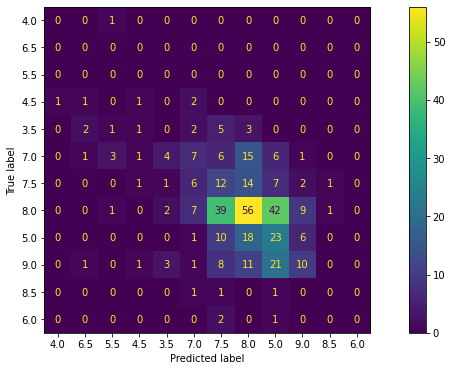

In [291]:
eval_all(y_test, y_pred, 'Prophet')

In [314]:
y_pred.reset_index(drop=True, inplace=True)

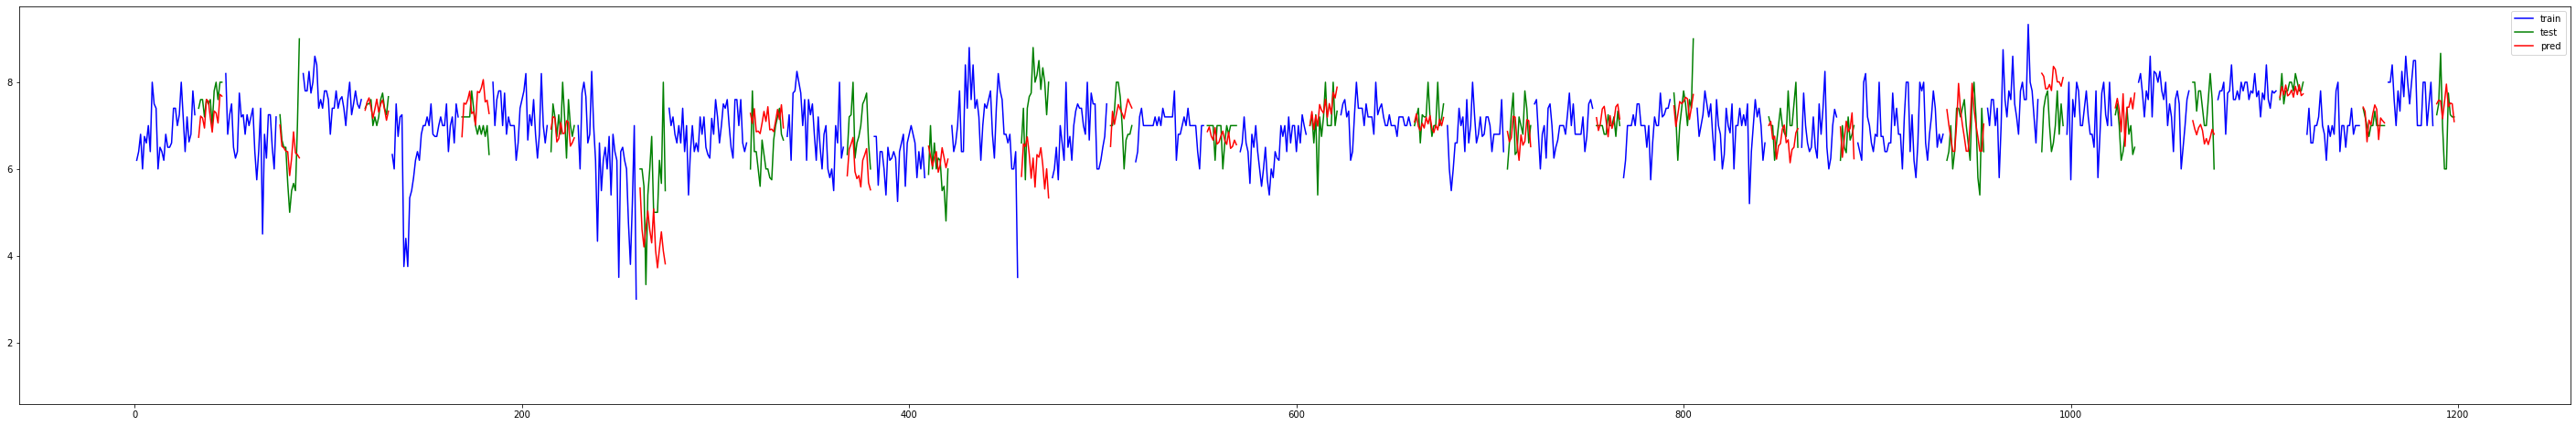

In [316]:
current_series_y = []
current_series_index = []
fig,ax = plt.subplots(figsize=(50,8))

i_prev = y_train.reset_index().iloc[0,:]['index']
for _,row in y_train.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='b')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
i_prev = y_test.reset_index().iloc[0,:]['index']
for _,row in y_test.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='g')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row['0'])
        current_series_index.append(row['index'])
    i_prev = row['index']

current_series_y = []
current_series_index = []
y_pred_rescaled = pd.concat([pd.DataFrame(y_test.index, columns=['index']), y_pred], axis=1).set_index('index')
i_prev = y_pred_rescaled.reset_index().iloc[0,:]['index']
for _,row in y_pred_rescaled.reset_index().iterrows():
    if row['index'] != i_prev + 1:
        ax.plot(current_series_index, current_series_y, c='r')
        current_series_y = []
        current_series_index = []
    else: 
        current_series_y.append(row[0])
        current_series_index.append(row['index'])
    i_prev = row['index']

l_train, = plt.plot([1], c='b')
l_test, = plt.plot([1], c='g')
l_pred, = plt.plot([1], c='r')



plt.legend([l_train, l_test, l_pred],['train', 'test', 'pred']);



## Evaluation (validation / test) 10

## Illustrate performance with graphs 10